In [1]:
# idea is plot average error at select depths along with temperature and voltage, maybe position as well?

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    16:43:27 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    16:43:27 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    16:43:27 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42343")
client

<Client: 'tcp://127.0.0.1:42343' processes=4 threads=16, memory=125.81 GiB>

In [4]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

In [5]:
def get_errors(ds,window,lag):
    # New method
    b1= ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    
    # Old Method
    b1= ds.isel(time=range(0,len(ds)-1))
    b2 = ds.isel(time=range(1,len(ds)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_old = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')
    vv_old = ds_old.range_diff.coarsen(time=lag,boundary='trim').sum()/ds_old.time_diff.coarsen(time=lag,boundary='trim').sum()*31536000
    vv_old_err = np.sqrt(((ds_old.err)**2).coarsen(time=lag,boundary='trim').sum())/ds_old.time_diff.coarsen(time=lag,boundary='trim').sum()*31536000
    fit_old=vv_old.where(vv_old.profile_range <=600).polyfit('profile_range',1,full=True)
    r2_old = 1-fit_old.polyfit_residuals/((vv_old-vv_old.mean())**2).sum(dim='profile_range')
    
   
    return vv,vv_err,vv_old,vv_old_err

In [28]:
def plot_errors(to_plot,lag,temp1,temp2,voltage,xlim=None):
    vv,vv_err,vv_old,vv_old_err = get_errors(to_plot,80,lag)
    fig, axs = plt.subplots(nrows=3,figsize=(10,9),sharex=True)
    for i in range(5):
        vv_err.isel(profile_range=i*5).plot(ax=axs[0],marker='.',linestyle='None',label=f'{int(vv_err.profile_range.isel(profile_range=i*5).values)} m')
    axs[0].legend()
    axs[0].set_title('Errors over depth')
    axs[0].set_xlabel('')
    axs[0].set_ylabel('velocity error [m y$^{-1}$')
    
    temp1.plot(ax=axs[1],label='Temperature 1')
    temp2.plot(ax=axs[1],label='Temperature 2')
    axs[1].set_xlabel('')
    axs[1].set_ylabel('ApRES temperature [C]')
    axs[1].legend()
    
    voltage.plot(ax=axs[2])
    axs[2].set_xlabel('time')
    axs[2].set_ylabel('battery voltage [V]')
    if xlim:
        axs[2].set_xlim(xlim)

# A11

## Summer 2022

In [25]:
to_plot = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)
temp1 = ds_101.temperature_1.compute()
true_temp1 = temp1.where(lambda x: x<300, temp1-512)

temp2 = ds_101.temperature_2.compute()
true_temp2 = temp2.where(lambda x: x<300, temp2-512)

voltage = ds_101.battery_voltage.compute()

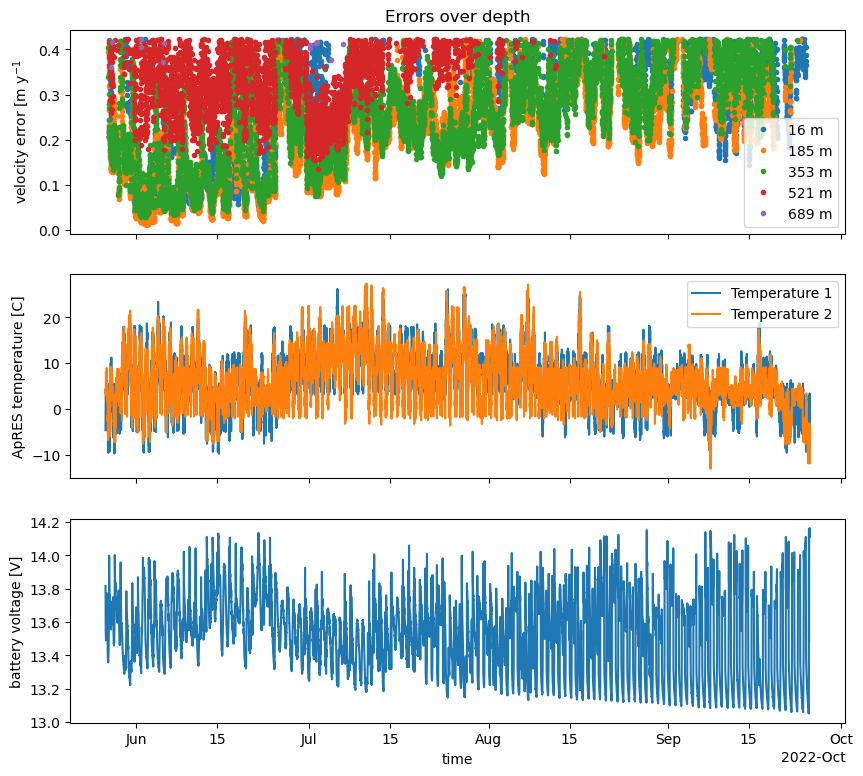

In [29]:
plot_errors(to_plot,96,true_temp1,true_temp2,voltage)

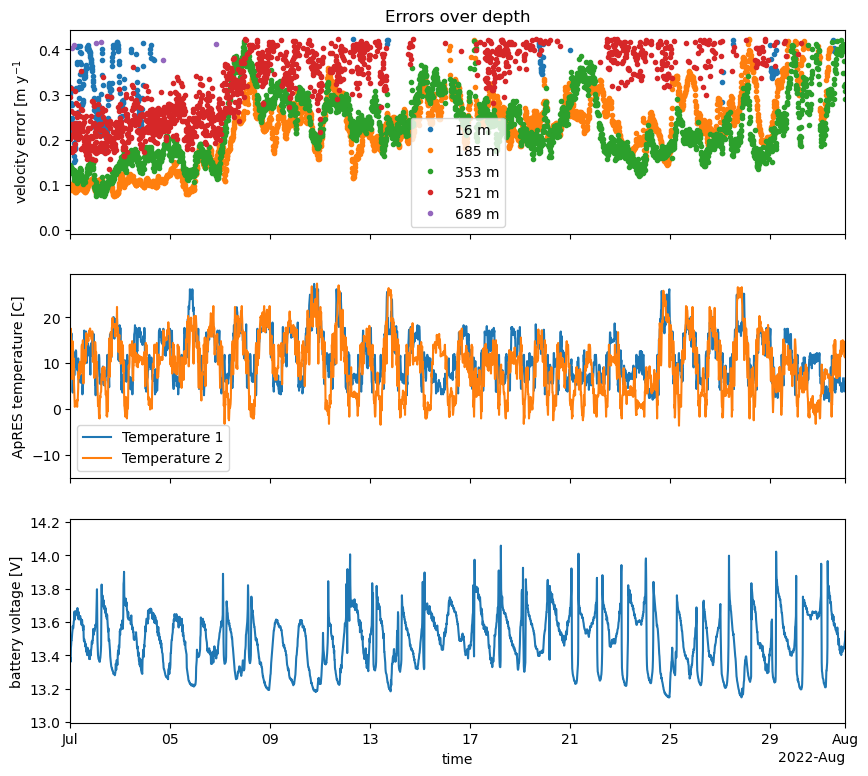

In [30]:
plot_errors(to_plot,96,true_temp1,true_temp2,voltage,[date(2022, 7, 1), date(2022, 8, 1)])

## Winter 2022 - 2023

In [34]:
to_plot = ds_101_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
temp1 = ds_101_w.temperature_1.compute()
true_temp1 = temp1.where(lambda x: x<300, temp1-512)

temp2 = ds_101_w.temperature_2.compute()
true_temp2 = temp2.where(lambda x: x<300, temp2-512)

voltage = ds_101_w.battery_voltage.compute()

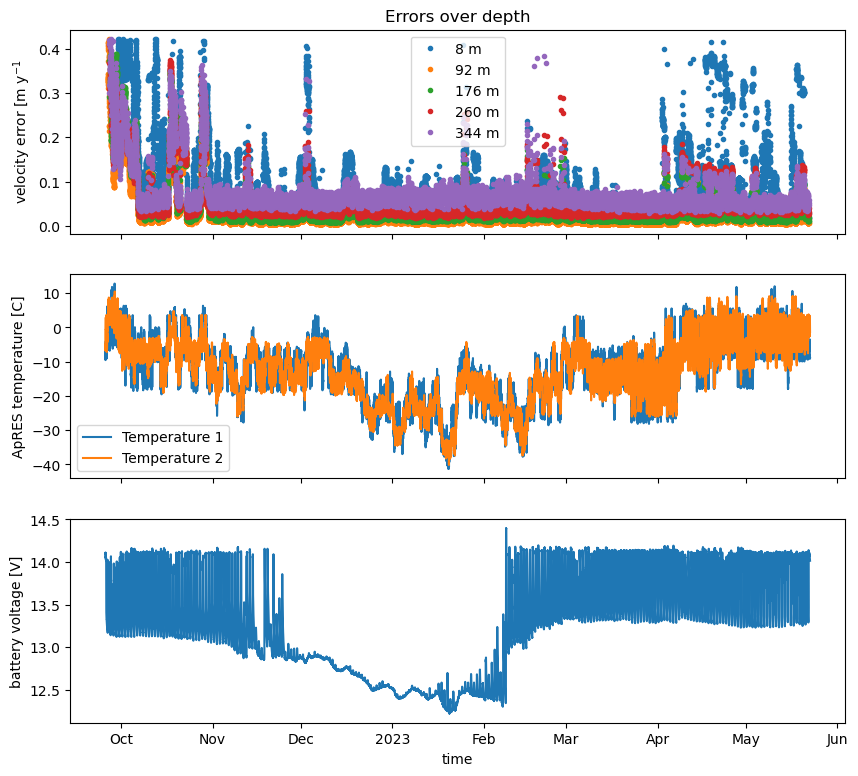

In [35]:
plot_errors(to_plot,96,true_temp1,true_temp2,voltage)

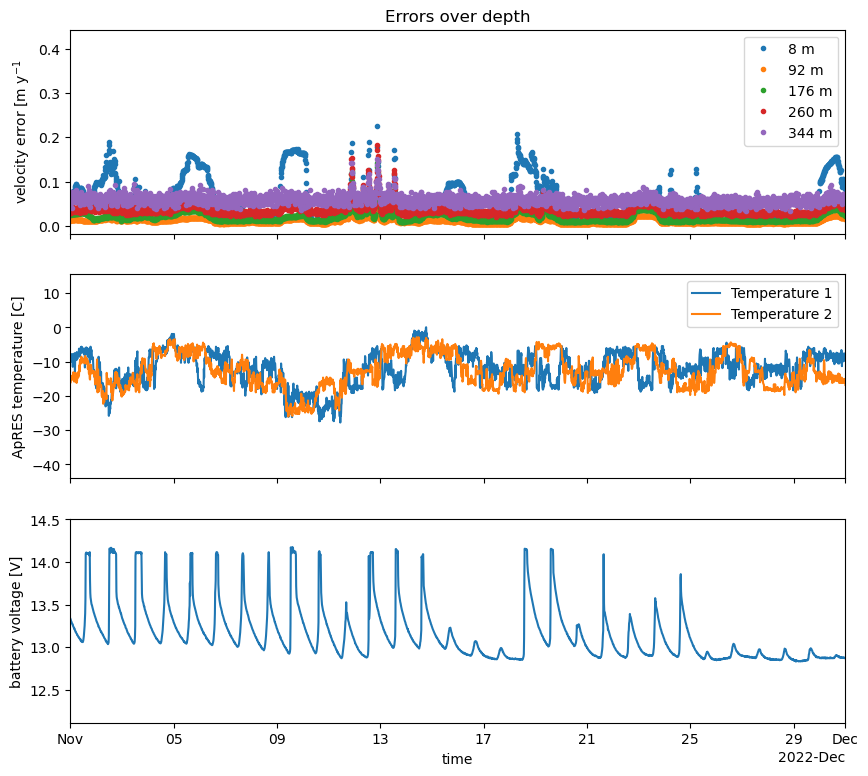

In [37]:
plot_errors(to_plot,96,true_temp1,true_temp2,voltage,[date(2022, 11, 1), date(2022, 12, 1)])

# A13

## Summer 2022

In [38]:
to_plot = custom_stacked_profile_series(ds_103.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)
temp1 = ds_103.temperature_1.compute()
true_temp1 = temp1.where(lambda x: x<300, temp1-512)

temp2 = ds_103.temperature_2.compute()
true_temp2 = temp2.where(lambda x: x<300, temp2-512)

voltage = ds_103.battery_voltage.compute()

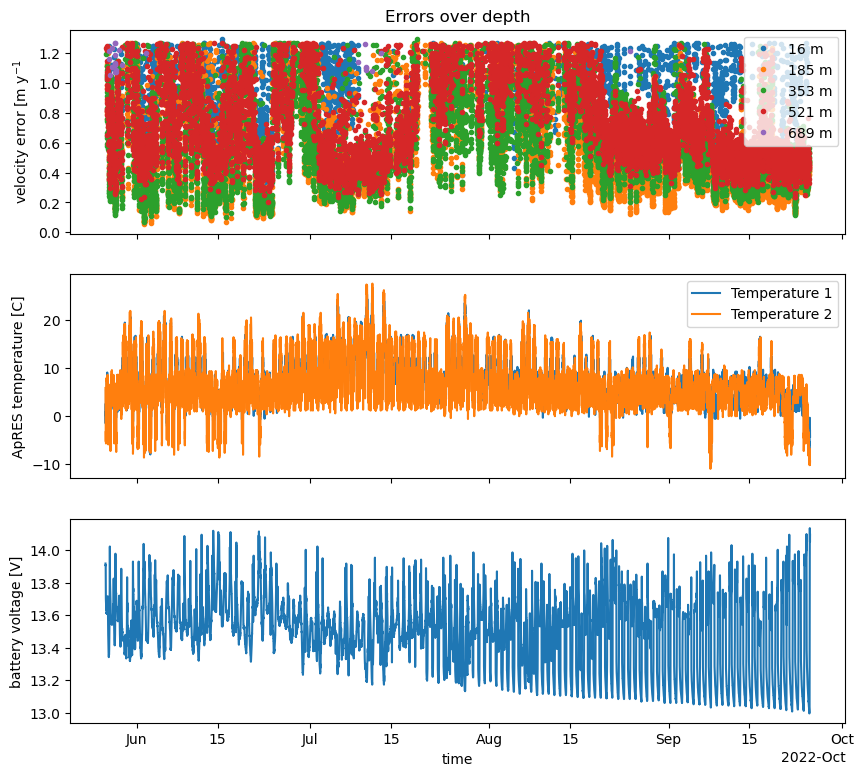

In [39]:
plot_errors(to_plot,32,true_temp1,true_temp2,voltage)

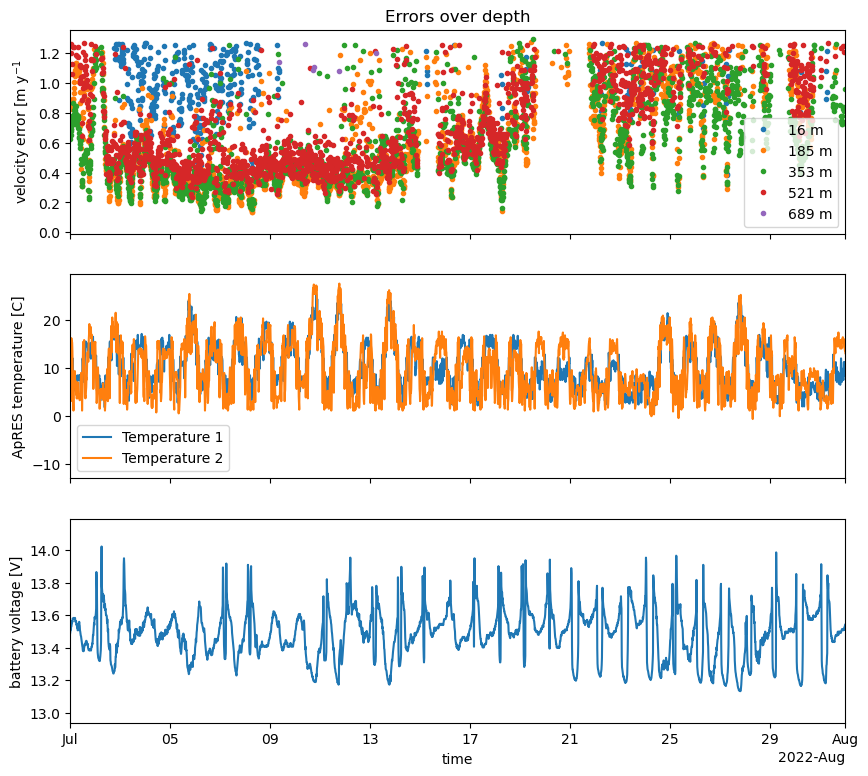

In [40]:
plot_errors(to_plot,32,true_temp1,true_temp2,voltage,[date(2022, 7, 1), date(2022, 8, 1)])

## Winter 2022 - 2023

In [41]:
to_plot = ds_103_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
temp1 = ds_103_w.temperature_1.compute()
true_temp1 = temp1.where(lambda x: x<300, temp1-512)

temp2 = ds_103_w.temperature_2.compute()
true_temp2 = temp2.where(lambda x: x<300, temp2-512)

voltage = ds_103_w.battery_voltage.compute()

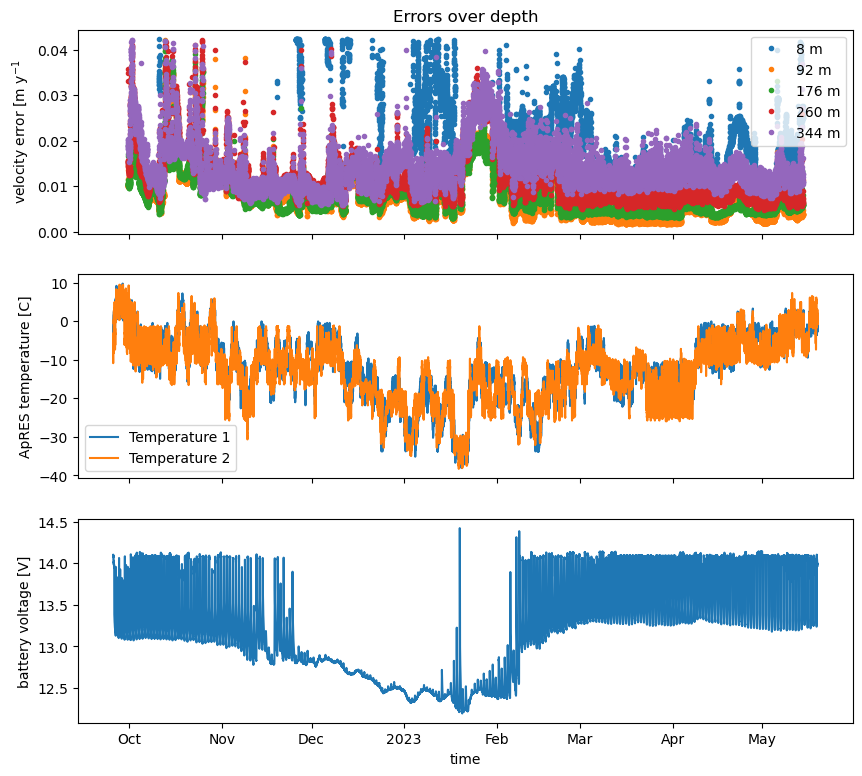

In [43]:
plot_errors(to_plot,960,true_temp1,true_temp2,voltage)

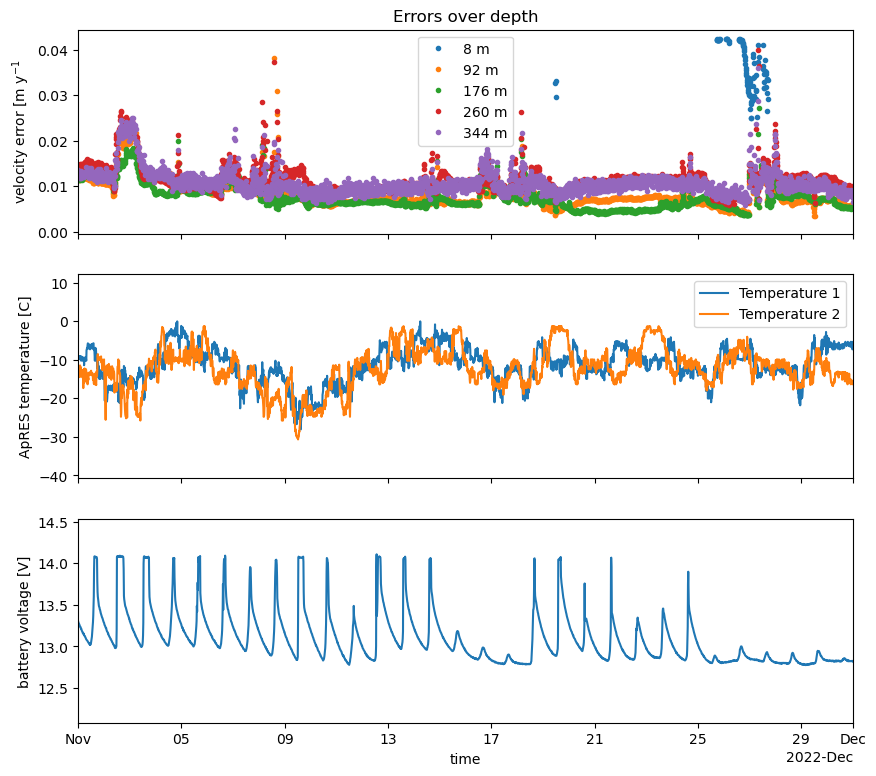

In [44]:
plot_errors(to_plot,960,true_temp1,true_temp2,voltage,[date(2022, 11, 1), date(2022, 12, 1)])

## Summer 2023

In [45]:
to_plot = custom_stacked_profile_series(ds_103_s.chirp.isel(attenuator_setting_pair=2),2,3e8,4e8)
temp1 = ds_103_s.temperature_1.compute()
true_temp1 = temp1.where(lambda x: x<300, temp1-512)

temp2 = ds_103_s.temperature_2.compute()
true_temp2 = temp2.where(lambda x: x<300, temp2-512)

voltage = ds_103_s.battery_voltage.compute()

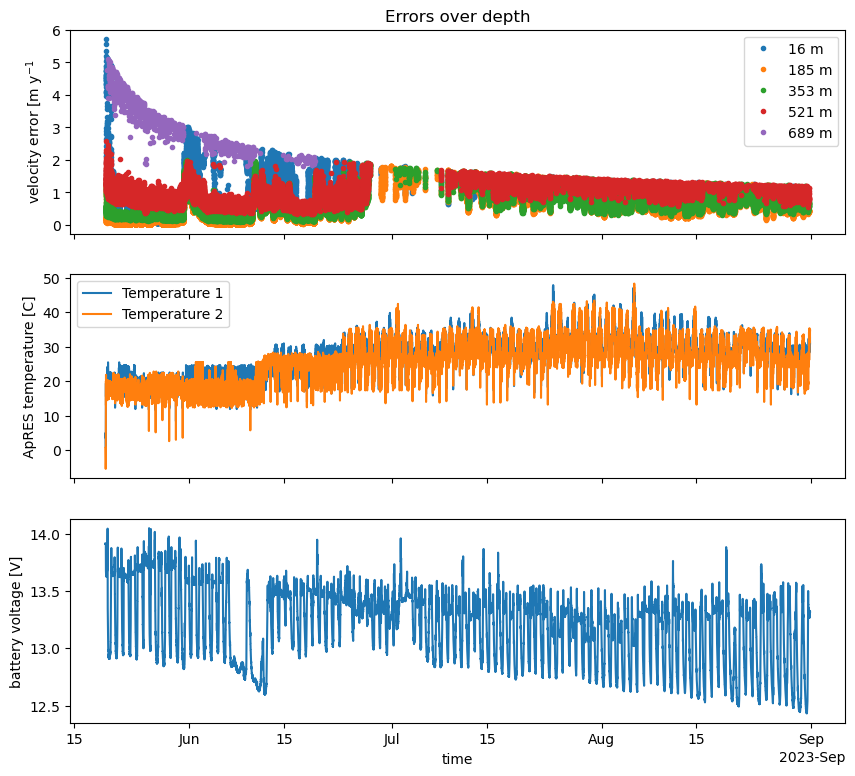

In [46]:
plot_errors(to_plot,100,true_temp1,true_temp2,voltage)

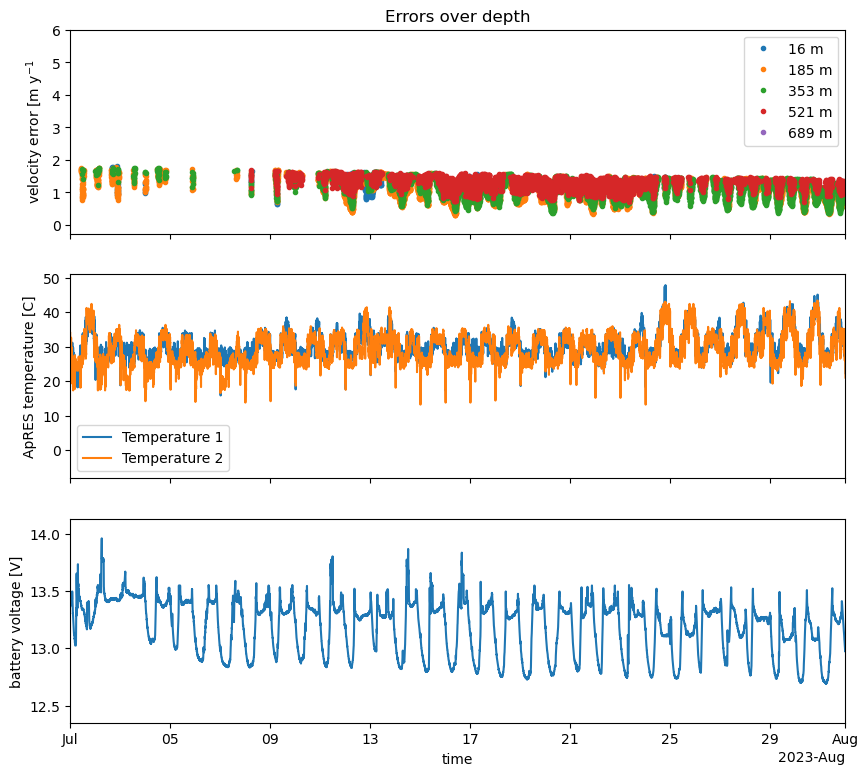

In [48]:
plot_errors(to_plot,100,true_temp1,true_temp2,voltage,[date(2023, 7, 1), date(2023, 8, 1)])

# A14

## Summer 2022

In [49]:
to_plot = ds_104.profile_stacked.isel(attenuator_setting_pair=0).compute()
temp1 = ds_104.temperature_1.compute()
true_temp1 = temp1.where(lambda x: x<300, temp1-512)

temp2 = ds_104.temperature_2.compute()
true_temp2 = temp2.where(lambda x: x<300, temp2-512)

voltage = ds_104.battery_voltage.compute()

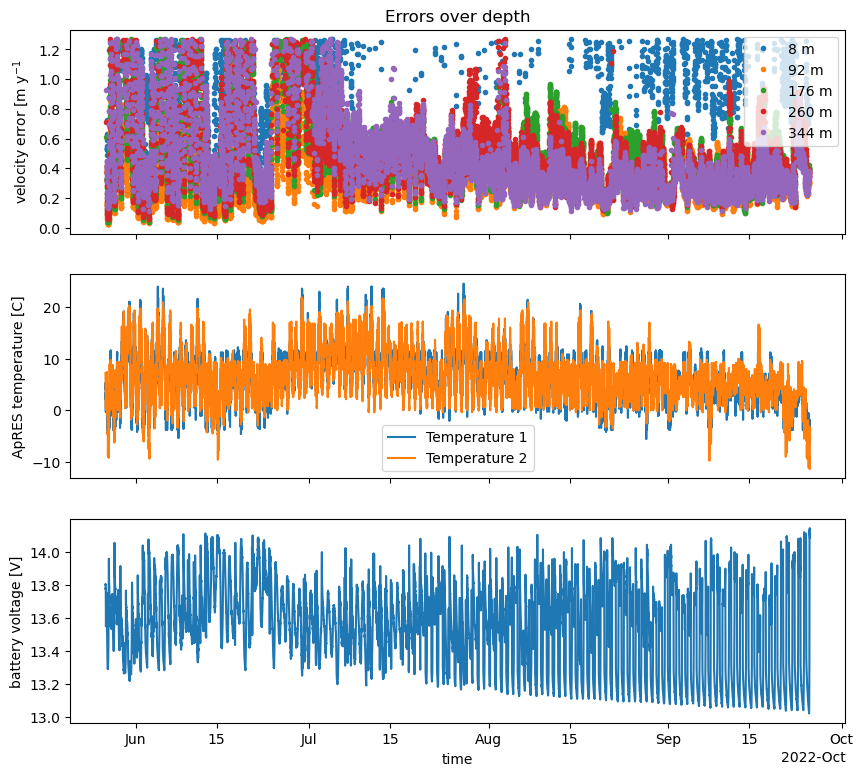

In [50]:
plot_errors(to_plot,32,true_temp1,true_temp2,voltage)

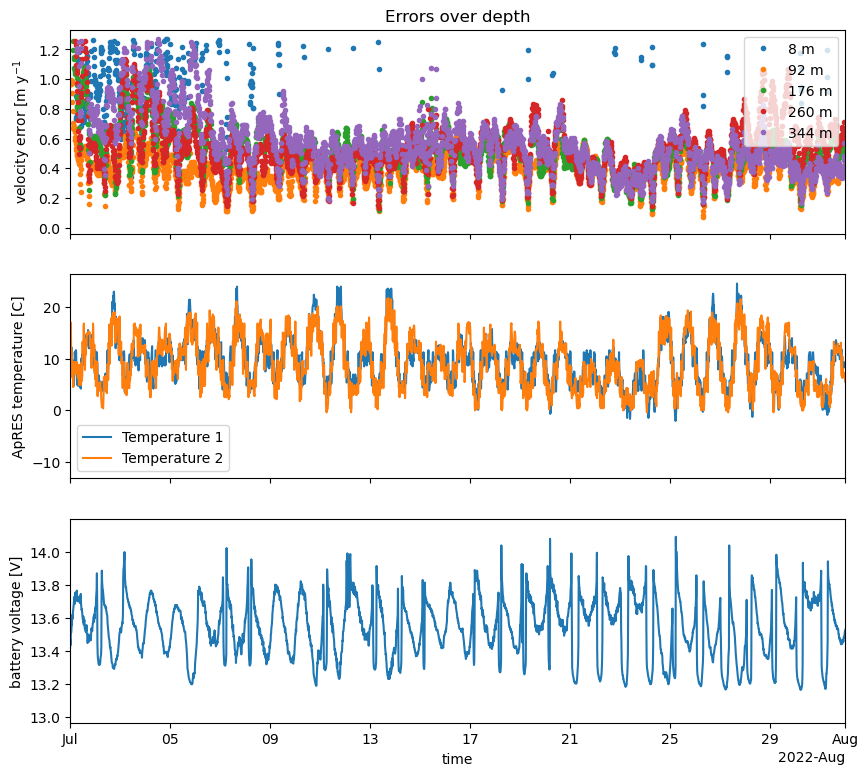

In [51]:
plot_errors(to_plot,32,true_temp1,true_temp2,voltage,[date(2022, 7, 1), date(2022, 8, 1)])

## Winter 2022 - 2023

In [52]:
to_plot = ds_104_w.profile_stacked.isel(attenuator_setting_pair=0).compute()
temp1 = ds_104_w.temperature_1.compute()
true_temp1 = temp1.where(lambda x: x<300, temp1-512)

temp2 = ds_104_w.temperature_2.compute()
true_temp2 = temp2.where(lambda x: x<300, temp2-512)

voltage = ds_104_w.battery_voltage.compute()

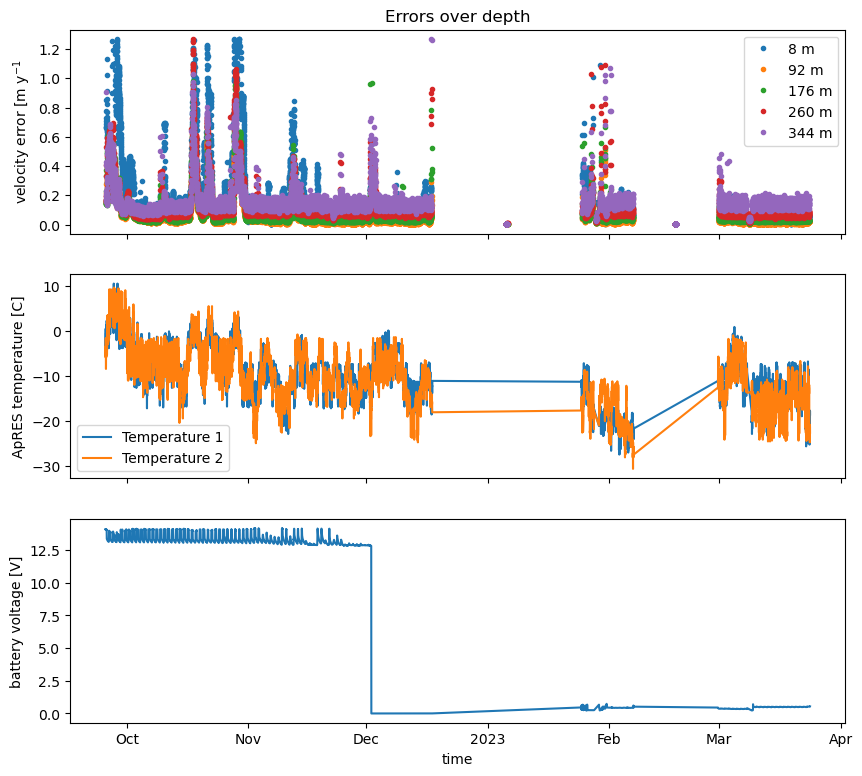

In [53]:
plot_errors(to_plot,32,true_temp1,true_temp2,voltage)

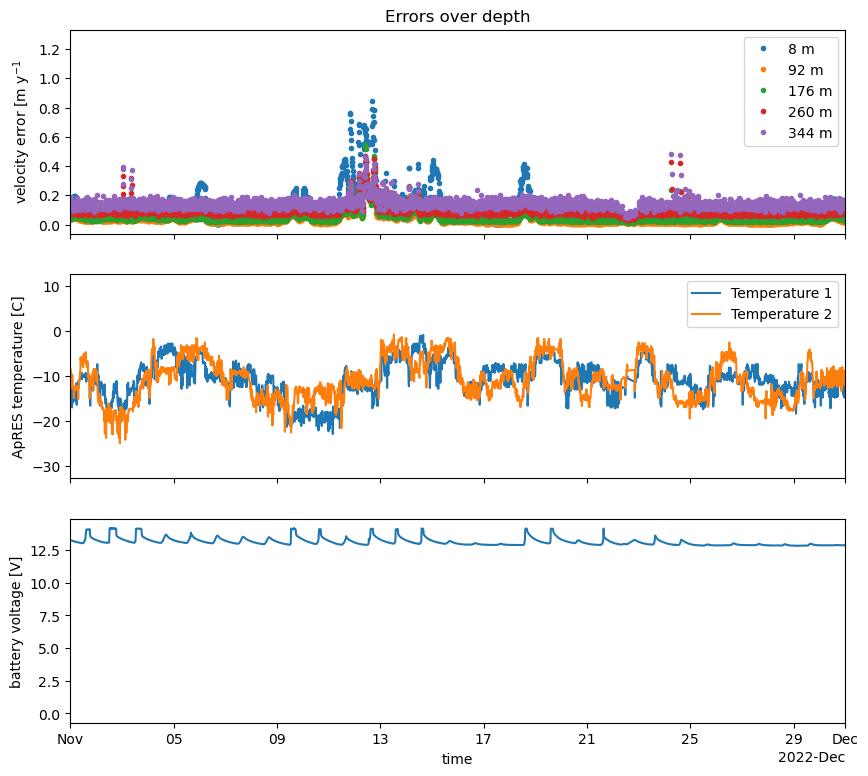

In [54]:
plot_errors(to_plot,32,true_temp1,true_temp2,voltage,[date(2022, 11, 1), date(2022, 12, 1)])

## Summer 2023

In [55]:
to_plot = custom_stacked_profile_series(ds_104_s.chirp.isel(attenuator_setting_pair=0),2,3e8,4e8)
temp1 = ds_104_s.temperature_1.compute()
true_temp1 = temp1.where(lambda x: x<300, temp1-512)

temp2 = ds_104_s.temperature_2.compute()
true_temp2 = temp2.where(lambda x: x<300, temp2-512)

voltage = ds_104_s.battery_voltage.compute()

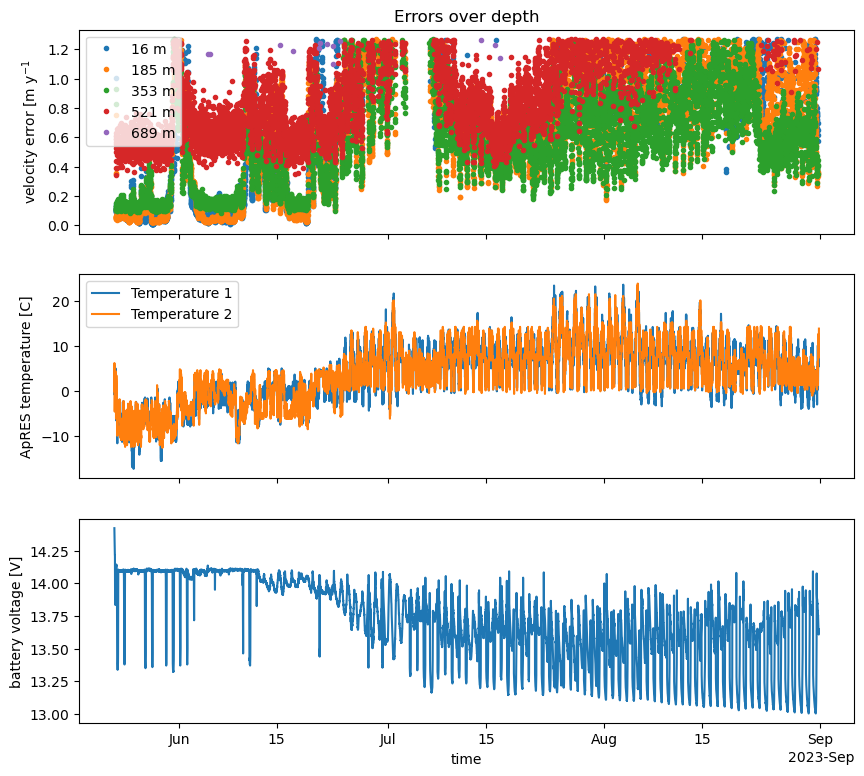

In [56]:
plot_errors(to_plot,32,true_temp1,true_temp2,voltage)

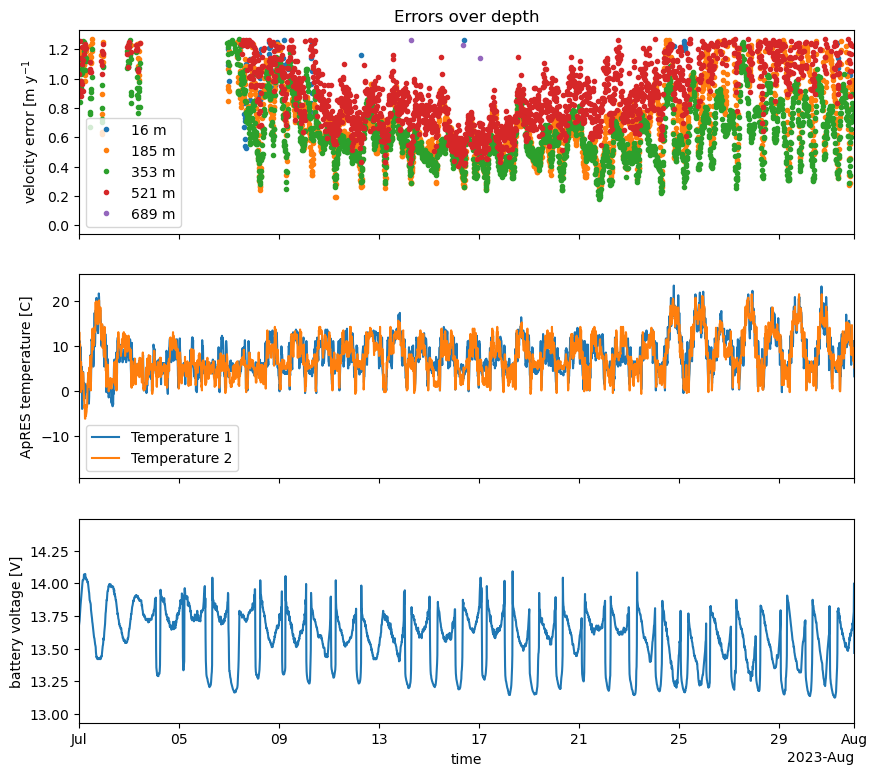

In [57]:
plot_errors(to_plot,32,true_temp1,true_temp2,voltage,[date(2023, 7, 1), date(2023, 8, 1)])

In [61]:
to_plot

<xarray.DataArray (time: 9705, profile_range: 3329)>
array([[ 8.21718525e-03+0.00000000e+00j, -2.88250432e-05-7.25154244e-03j,
        -4.90960639e-03+3.08437986e-05j, ...,
        -1.91179171e-07+1.43824108e-05j,  1.04247862e-05+2.11362840e-06j,
         2.31188770e-06-1.08546648e-05j],
       [ 8.24101935e-03+0.00000000e+00j, -2.45805851e-05-7.26488633e-03j,
        -4.90811868e-03+2.73771353e-05j, ...,
         1.05608885e-05+8.59061729e-06j,  1.41967531e-05-1.27578042e-05j,
        -1.19160232e-05-1.37308912e-05j],
       [ 8.21773978e-03+0.00000000e+00j, -1.22911935e-05-7.25310853e-03j,
        -4.90589517e-03+1.08351896e-05j, ...,
         5.70218474e-07+9.69903140e-07j,  1.76642832e-06+5.55872449e-07j,
         1.42211602e-06-2.38706188e-06j],
       ...,
       [ 7.96150592e-03+0.00000000e+00j,  2.70891176e-05-7.00320647e-03j,
        -4.68868684e-03-3.22084033e-05j, ...,
        -4.62312919e-07+6.70052300e-06j,  4.28775506e-06+3.67307781e-07j,
         3.77337945e-07-1.62883756e-06j],
       [ 7.96018608e-03+0.00000000e+00j,  2.93357060e-05-7.00188352e-03j,
        -4.68831829e-03-3.60598725e-05j, ...,
        -7.76485376e-06+2.11753754e-05j,  1.68768481e-05+7.90289603e-06j,
         8.80520056e-06-1.13706846e-05j],
       [ 7.96972596e-03+0.00000000e+00j,  3.03208679e-05-7.00973163e-03j,
        -4.69336933e-03-3.79329621e-05j, ...,
        -4.27542006e-06+9.77693345e-06j,  8.26522830e-06+3.00261321e-06j,
         1.06505211e-06-4.99331351e-06j]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.4206 ... 1.399e+03 1.4e+03
  * time           (time) datetime64[ns] 2023-05-22T17:04:27 ... 2023-08-31T1...

In [72]:
vv,vv_err,vv_old,vv_old_err = get_errors(to_plot,80,32)
temps = np.interp(vv_err.time,true_temp2.time,true_temp2.values)


array([nan])

In [79]:
import numpy.ma as ma

ma.corrcoef(ma.masked_invalid(vv_err.mean(dim='profile_range').values),ma.masked_invalid(temps))

masked_array(
  data=[[1.0, 0.5711679363046092],
        [0.5711679363046092, 1.0]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)